In [38]:
import pickle
import os
import tweepy
import pandas as pd
import nltk
from textblob import TextBlob
from operator import itemgetter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
import re #module used to work with regular expressions
from nltk.tokenize import word_tokenize
from string import punctuation
from nltk.corpus import stopwords
from IPython.display import Image


In [ ]:
consumerKey = 'xxx'
consumerSecret = 'xxx'
accessToken = 'xxx-xxx'
accessTokenSecret = 'xxx'

auth = tweepy.OAuthHandler(consumerKey, consumerSecret)
auth.set_access_token(accessToken, accessTokenSecret)
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [ ]:
keyword = "bansos"
date_since = "2020-01-01"
new_search = keyword + " -filter:retweets"

tweets = tweepy.Cursor(api.search,
        q=new_search,
        lang="id",
        since=date_since).items(50)

tanggal = []
user = []
author = []
teks = []
for tweet in tweets:
    tanggal.append(tweet.created_at)
    user.append(tweet.user.name)
    author.append(tweet.author.screen_name)
    teks.append(tweet.text)

tanggal = pd.DataFrame(data=(tanggal), columns=['tanggal'])
tanggal.insert(0, 'Nomor', range(0, 0 + len(tanggal)))
a = tanggal
    
user = pd.DataFrame(data=user, columns=['user'])
user.insert(0, 'Nomor', range(0, 0 + len(user)))
b = user

author = pd.DataFrame(data=(author), columns=['author'])
author.insert(0, 'Nomor', range(0, 0 + len(author)))
c = author

teks = pd.DataFrame(data=(teks), columns=['teks'])
teks.insert(0, 'Nomor', range(0, 0 + len(teks)))
d = teks

e = a.merge(b, how='inner', left_on=['Nomor'], right_on=['Nomor']) #Join
f = c.merge(d, how='inner', left_on=['Nomor'], right_on=['Nomor']) #Join
dataraw = e.merge(f, how='inner', left_on=['Nomor'], right_on=['Nomor']) #Join
dataraw.to_excel('datatest.xlsx', sheet_name = 'dataraw', index = 'Nomor')

In [18]:
df = pd.read_excel('dataraw.xlsx', sheet_name = 'dataraw', engine='openpyxl')
df.drop(columns=['Unnamed: 0', 'Nomor'], inplace=True)

def trainingData():
    trainingData = [{'text':row[4], 'label':row[1]} for index,row in df.iterrows()]
    return trainingData

df.head()

,TweetDate,author,TweetId,Sentiment,TweetText
0,2021-01-07 12:39:17.000001,prulin3,#pakaimaskerjagajarak,positif,@tsetiady pasti alasannya karena ekonomi.. Kal...
1,2021-01-07 12:39:10.000000,heri_ciko,ciko,negatif,@Rizmaya__ Buanggsattt bgt TOGOG...\nBansos tr...
2,2021-01-07 12:37:06.999999,sena_mandra,Mandra Sena,netral,@aniesbaswedan @HumasFatmawati @dinkesJKT @Kem...
3,2021-01-07 12:37:06.000000,unsar_TATAart,MENDOAN ANGET,negatif,@moechaaliem @damai_114 @Permadi1987 hari gini...
4,2021-01-07 12:36:56.000000,gunaditaufiq,gunadi taufiq,negatif,@idtodayco Korupsi bansos\nKorupsi citra sos


In [39]:
dftest = pd.read_excel('datatest.xlsx', sheet_name = 'dataraw', engine='openpyxl')
dftest.drop(columns=['Unnamed: 0', 'Nomor'], inplace=True)

def tweet():
    tweet = [{'text':row[3], 'label':row[1]} for index,row in dftest.iterrows()]
    return tweet

dftest.head()

,TweetDate,author,TweetId,TweetText
0,2021-01-07 14:36:48.000000,TEMPO.CO,tempodotco,Sekretaris Perusahaan Bank DKI Herry Jufraini ...
1,2021-01-07 14:36:29.000000,Melattica,_melattica_,@rezasnegara Sembari berbincang masalah dana b...
2,2021-01-07 14:36:16.000000,#KamiOposisi,Anaksemut4,@arwanjazz @VIVAcoid Kok nyinyir... bukannya y...
3,2021-01-07 14:34:51.000000,vespajelata,militanvespa,@Bisniscom Bansos d korup sedih gak?
4,2021-01-07 14:34:26.999999,NADIA,akulahnadia,"""Bersumber dari jual lobster kah uang yang ada..."


In [40]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
stop_factory = StopWordRemoverFactory()
more_stopword = ['dengan','yg','ia','bahwa’,’oleh','kayak', 'nya', 'gak', 'ga', 'aja']
data = stop_factory.get_stop_words()+more_stopword
stopword = stop_factory.create_stop_word_remover()


cached_stop_words = data
cached_stop_words = set(cached_stop_words)
df['TweetText'] = [' '.join([w for w in x.lower().split() if w not in cached_stop_words]) 
    for x in df['TweetText'].tolist()]
# dftest['TweetText'] = [' '.join([w for w in x.lower().split() if w not in cached_stop_words]) 
#     for x in dftest['TweetText'].tolist()]

In [41]:
# tweets = tweet()
# # tweets[:3]



In [42]:
# Creating a class to preprocess the test and training tweets

class Preprocess:
    def __init__(self):
        
        lst = ['AT_USER','URL','rt','...', '..', "'s", "n't", "``", "''", 'bu']
        self._stopwords = set(stopwords.words('indonesian')+list(punctuation)+lst)
        
        
    def processTweets(self, tweets):
        #tweets is a list of dict with Keys, 'text' and 'label'
        processedTweets = []
        #this list will be a list of tuple. Each tuple is a tweet which is a list of words and its label
        
        for tweet in tweets:
            processedTweets.append((self.cleanTweet(tweet['text']),tweet['label']))
                                         #it will apply the cleanTweet function only to the tweets text
        return processedTweets
    
    
    def processTweets_words(self, tweets):
        
        processedTweets = []
        #this list will be a list of each word in all tweets
        
        for tweet in tweets:
            processedTweets.append(self.cleanTweet(tweet['text']))
                                         #it will apply the cleanTweet function only to the tweets text
        return processedTweets
            
        
    def cleanTweet(self,tweet):
        #1 - Convert to lower case
        tweet = tweet.lower()
                
        #2 - Replace links with word 'URL'
        tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL',tweet)
        
        #3 - Replace @username with 'AT_USER'
        tweet = re.sub('@[^\s]+','AT_USER',tweet)
        
        #4 - Repalce #word (hashtag) with just the word, witouth the '#' simble
        tweet=re.sub(r'#([^\s]+)',r'\1',tweet)
        
        #5 - Remove emoticons
        tweet = tweet.encode('ascii', 'ignore').decode('ascii')
        
        #6 - Tokenizing the tweets
        tweet = word_tokenize(tweet)
        
       
        #7 - Removing stopwords 
        return [word for word in tweet if word not in self._stopwords]        

In [43]:
# Instantiating a Preprocess Class called 'tprocessor'
tprocessor = Preprocess()

# Creating an object that will contain the result of the TRAINING DATA after been preprocessed by the
# 'tprocessor' class
cleanedtrainingData = tprocessor.processTweets(training_Data)

# Creating an object that will contain the result of the TEST DATA after been preprocessed by the
# 'tprocessor' class
cleanedtestData = tprocessor.processTweets(tweet)

TypeError: 'function' object is not iterable

In [44]:
print(cleanedtestData[:10])

NameError: name 'cleanedtestData' is not defined

In [45]:
print(cleanedtrainingData[:10])

[(['alasannya', 'ekonomi', 'lockdown', 'negeri', 'setauku', 'dapet', 'bansos', 'beneran'], 'prulin3'), (['buanggsattt', 'bgt', 'togog', 'bansos', 'trilinunan', 'diem', 'koruptir', '5,6t', 'buanggtsatttt', 'togog'], 'heri_ciko'), (['jg', 'pejuang', 'pejuang', 'kesehatan', 'molo'], 'sena_mandra'), (['gini', 'ributin', 'cebong', 'kampret', 'darurat', 'negara', 'collap'], 'unsar_TATAart'), (['korupsi', 'bansos', 'korupsi', 'citra', 'sos'], 'gunaditaufiq'), (['penerima', 'bansos', 'dilarang', 'pakai', 'duit', 'bansos', 'beli', 'rokok', 'inga', 'inga', 'ting'], 'heri015'), (['bansos', 'mentri', 'kader', 'pdip', 'ya'], 'kepobingits11'), (['blusukan', 'koq', 'sudirman', 'thamrin', 'dicari', 'blusukan', 'tuh', 'basecamp', 'parpol', 'sarang', 'koruptor', 'cari', 'har'], 'jajatplus'), (['lo', 'sekandang', 'pura2', 'keciptratan', 'cie', 'cie', 'sih', 'gk', 'mema'], 'zem_tandi'), (['kader', 'maling', 'bansos', 'malu'], 'Kopipahitgitulo')]


In [46]:
# the result of the 'processTweets_words' is a list fo lists, so it will be necessary unify all words in
# only one list
words = tprocessor.processTweets_words(training_Data)

unif_words =[]
for i in words:
    for j in i:
        unif_words.append(j)
        
unif_words[:5]

['alasannya', 'ekonomi', 'lockdown', 'negeri', 'setauku']

In [47]:
# word frequence using 'Counter' class from the 'collection' package

from collections import Counter

word_counter = Counter(unif_words)

In [48]:
most_common_words = word_counter.most_common()[:15]
print(most_common_words)

[('bansos', 181), ('korupsi', 43), ('sedih', 30), ('dana', 29), ('kader', 19), ('uang', 17), ('duit', 16), ('maling', 16), ('rakyat', 15), ('partai', 15), ('pdip', 13), ('heran', 11), ('dikorupsi', 11), ('covid', 11), ('masyarakat', 10)]


In [49]:
# Converting the dictionary to a pandas DataFrame
df = pd.DataFrame(most_common_words, columns=['word','freq'])

# sorting the words based on their frequence
df = df.sort_values(by=['freq'], ascending=False)

# getting the top 20 more frequent words
top_20 = df.head(20)
top_20

,word,freq
0,bansos,181
1,korupsi,43
2,sedih,30
3,dana,29
4,kader,19
5,uang,17
6,duit,16
7,maling,16
8,rakyat,15
9,partai,15


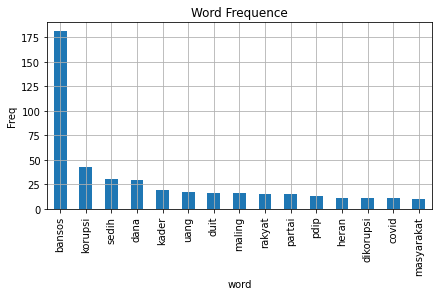

In [15]:
# Bar ploting from the top 20 more frequent words

axes = top_20.plot.bar(x='word',y='freq',legend=False)
plt.gcf().tight_layout()
plt.ylabel('Freq')
plt.grid()
plt.title('Word Frequence')
plt.show()

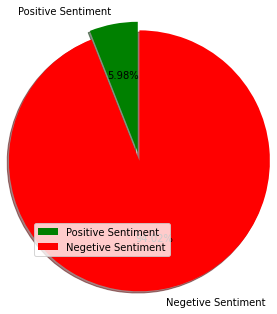

In [19]:
sentiments = ['Positive Sentiment', 'Negetive Sentiment'] 
slices = [(df['Sentiment'] == 'positif').sum(), (df['Sentiment'] == 'negatif').sum()] 
colors = ['g', 'r'] 
plt.pie(slices, labels = sentiments, colors=colors, startangle=90, shadow = True,
        explode = (0, 0.1), radius = 1.5, autopct = '%1.2f%%') 
plt.legend()
plt.show() 

In [51]:
dic = {}
for item in unif_words:
    dic[item] = dic.get(item, 0) + 1
dic

{'alasannya': 2,
 'ekonomi': 2,
 'lockdown': 1,
 'negeri': 2,
 'setauku': 1,
 'dapet': 1,
 'bansos': 181,
 'beneran': 2,
 'buanggsattt': 1,
 'bgt': 1,
 'togog': 2,
 'trilinunan': 1,
 'diem': 4,
 'koruptir': 1,
 '5,6t': 1,
 'buanggtsatttt': 1,
 'jg': 4,
 'pejuang': 2,
 'kesehatan': 1,
 'molo': 1,
 'gini': 2,
 'ributin': 1,
 'cebong': 2,
 'kampret': 1,
 'darurat': 1,
 'negara': 3,
 'collap': 1,
 'korupsi': 43,
 'citra': 1,
 'sos': 1,
 'penerima': 6,
 'dilarang': 1,
 'pakai': 1,
 'duit': 16,
 'beli': 1,
 'rokok': 1,
 'inga': 2,
 'ting': 1,
 'mentri': 4,
 'kader': 19,
 'pdip': 13,
 'ya': 4,
 'blusukan': 3,
 'koq': 1,
 'sudirman': 1,
 'thamrin': 1,
 'dicari': 1,
 'tuh': 7,
 'basecamp': 1,
 'parpol': 3,
 'sarang': 1,
 'koruptor': 8,
 'cari': 2,
 'har': 1,
 'lo': 1,
 'sekandang': 1,
 'pura2': 1,
 'keciptratan': 1,
 'cie': 2,
 'sih': 3,
 'gk': 3,
 'mema': 1,
 'maling': 16,
 'malu': 7,
 'nanya': 1,
 'kak': 1,
 'niat': 1,
 'bagi-bagi': 1,
 'kepemimpinan': 1,
 'payaaahh': 1,
 'disalahkan': 1,
 'y

In [23]:
# Bulding a World Cloud



wordcloud = WordCloud(width=2000,   height=900,
                      prefer_horizontal=0.5,
                      min_font_size=10,
                      colormap='prism')

wordcloud = wordcloud.fit_words(dic)

wordcloud = wordcloud.to_file('bansos.png')


#IMPORTANT!!!

#The result will create a png file in the fouder where the jupyter notebook are running. In order to see the
#result you will need to go check this file

In [24]:
Image(url = 'bansos.png',width=700, unconfined=True)

In [25]:
#Defining the function to create a word Vocabulary or bag_of_words

def wordVocab(cleanedtrainingData):
    training_features = []
    for (words, sentiment) in cleanedtrainingData:
        training_features.extend(words)
    return list(set(training_features))

In [26]:
#Creating the word_features_vocab object

word_features_vocab = wordVocab(cleanedtrainingData)

In [27]:
# The NLTK library have a function called apply_features that takes a user-defined function to extract
# featrues from training data. In this case the function will be called extract_features_func that will
# take each tweet in the in the training data and repersent it with the presence or absence of a word in
# the vocabulary, as previously explaned in the item 2.2 above.

def extract_features_func(tweet):
    tweet_words = set(tweet)
    features = {}
    for word in word_features_vocab:
        features[f'contains {word}'] = (word in tweet_words)
        # this step will creat a dictionary with keys like 'contains word1' and 'contains word2', and values
        # as True or False. The statement that create the True or False return is the '(word in tweet_words)'
        
    return features

In [28]:
# Creating the traning_features object

# apply_features will take the extract_features_func defined above, and apply it to each element of
# cleanedtrainingData. it automatically recognize that each of these elements are tuples where the
# first element is the text and the second is the label. The apply_features apply the extract_features_func
# only on the text element.

trainingFeature = nltk.classify.apply_features(extract_features_func,cleanedtrainingData)



In [29]:
# Creating the classifier objected, trained using the training data features 

NBclassifier = nltk.NaiveBayesClassifier.train(trainingFeature)


In [30]:
sentiment_classifier = [NBclassifier.classify(extract_features_func(tweet[0])) for tweet in cleanedtestData]
sentiment_classifier

NameError: name 'cleanedtestData' is not defined

In [33]:
print('-='*40)
print('{:^80}'.format('SENTIMENT RESULTS USING NAIVE BAYES CLASSIFIER'))
print('-='*40)
print('')


if sentiment_classifier.count('positif'):
    print('Positif Sentiment = {:.2f}'.format(100*sentiment_classifier.count('positif')/len(sentiment_classifier))+"%")
          
if sentiment_classifier.count('negatif'):
    print('Negatif Sentiment = {:.2f}'.format(100*sentiment_classifier.count('negatif')/len(sentiment_classifier))+"%")
    
if sentiment_classifier.count('netral'):
    print('Netral Sentiment = {:.2f}'.format(100*sentiment_classifier.count('netral')/len(sentiment_classifier))+"%")
    
if sentiment_classifier.count('tidak relevan'):
    print('Netral Sentiment = {:.2f}'.format(100*sentiment_classifier.count('tidak relevan')/len(sentiment_classifier))+"%")

if sentiment_classifier.count('tidak relevan') or sentiment_classifier.count('tidak relevan') == 0:
    print('Irrelevant Sentiment = {:.2f}'.format(100*sentiment_classifier.count('tidak relevan')/len(sentiment_classifier))+"%")
    

print('')
print('-='*40)
print('{:^80}'.format('First 10 tweets'))
print('-='*40)



-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
                 SENTIMENT RESULTS USING NAIVE BAYES CLASSIFIER                 
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=



NameError: name 'sentiment_classifier' is not defined

In [31]:
from textblob.sentiments import NaiveBayesAnalyzer

def get_tweets3(word='google',number=5, since='2019-11-01', until='2019-11-28'):

    search_term = str(input('Hi! What are you looking for today? - '))
    num_of_terms = int(input('How many tweets do you want? - '))
    since = input('From which date? ex.: 2019-11-01 - ')
    until = input('Until which date? ex.: 2019-11-28 - ')

    tweets = tweepy.Cursor(api.search,
                                #since = f'{since},
                                #until = f'{until},
                                q=search_term,
                                lang='en').items(num_of_terms)                                
                                
    
    positive = 0
    negative = 0

    for tweet in tweets:
        
        blob = TextBlob(tweet.text, analyzer=NaiveBayesAnalyzer())

        if blob.sentiment.p_pos > blob.sentiment.p_neg:
            positive += 1
        else:
            blob.sentiment.p_pos < blob.sentiment.p_neg
            negative += 1

                
    print()
    print('-=' * 3, 'TOTALS', '-=' * 3)
    print('Total Positives:', positive)
    print()
    print('Total Negatives:', negative)
    print()
    print()
    print('-=' * 3, 'PERCENTAGE', '-=' * 3)
    print(int((positive / num_of_terms) * 100), '% Positives')
    print()
    print(int((negative / num_of_terms) * 100), '% Negatives')
    print()
    
    return positive, negative